In [15]:
import torch
import polars as pl 
import matplotlib.pyplot as plt
import plotly.graph_objects as go
import plotly.io as pio

%load_ext autoreload
%autoreload 2

if torch.cuda.is_available():
    print("Using CUDA")
    device = torch.device('cuda')
else:
    print("Using CPU")
    device = torch.device('cpu')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using CUDA


In [16]:
# data_df = pl.read_csv("data/google_stock_price_train_standardized.csv")
data_df = pl.read_csv("data/google_stock_price_train_yfinance.csv")

data_df

Close,High,Low,Open,Volume,Date
f64,f64,f64,f64,f64,str
-0.975638,-0.975435,-0.974581,-0.974743,0.459015,"""2004-12-13"""
-0.968735,-0.97075,-0.974454,-0.975724,2.141593,"""2004-12-14"""
-0.967822,-0.969196,-0.968484,-0.969863,2.244269,"""2004-12-15"""
-0.970595,-0.969362,-0.969084,-0.970735,1.466501,"""2004-12-16"""
-0.96757,-0.969354,-0.968577,-0.970895,1.148062,"""2004-12-17"""
…,…,…,…,…,…
3.673084,3.771486,3.705525,3.777819,-0.556128,"""2021-11-30"""
3.645031,3.767172,3.686308,3.736147,-0.643782,"""2021-12-01"""
3.717635,3.706328,3.668721,3.655733,-0.692081,"""2021-12-02"""


In [17]:
from scipy.signal import argrelextrema
import numpy as np

# create col of zeros for now
minimas = pl.Series("minimas", [0] * len(data_df))
minima_indices = argrelextrema(data_df['Close'].to_numpy(), np.less, order=20)[0]
print(minima_indices)
minimas[minima_indices] = 1

# RSI
window_rsi = 14
delta = data_df["Close"].diff().alias("delta")

gain = delta.clip(lower_bound=0)
loss = -delta.clip(upper_bound=0)

avg_gain = gain.rolling_mean(window_size=window_rsi, min_periods=1)
avg_loss = loss.rolling_mean(window_size=window_rsi, min_periods=1)

rs = avg_gain / avg_loss

# MACD
short_span = 12
long_span = 26
signal_span = 9

macd = data_df["Close"].ewm_mean(span=short_span, adjust=False) - data_df[ "Close" ].ewm_mean(span=long_span, adjust=False)
signal = macd.ewm_mean(span=signal_span, adjust=False)

# Bollinger Bands
window_bollinger = 20
mid = data_df['Close'].rolling_mean(window_size=window_bollinger)
upper = mid + 2 * data_df['Close'].rolling_std(window_size=window_bollinger)
lower = mid - 2 * data_df['Close'].rolling_std(window_size=window_bollinger)


data_df = data_df.with_columns(
    pl.col("Close").rolling_mean(20).alias("sma_20"),
    rs / (1 + rs).alias("rsi") / 100,
    macd.alias("MACD"),
    signal.alias("Signal"),
    upper.alias("Upper"),
    lower.alias("Lower"),
    pl.col('Date').str.to_datetime().dt.weekday().alias("Day") / 7,
    pl.col('Date').str.to_datetime().dt.month().alias("Month") / 12,
    minimas
)

data_df

[  29   62  174  212  313  361  412  512  557  608  673  739  814  916
  963  995 1032 1065 1148 1309 1369 1399 1439 1502 1575 1645 1684 1714
 1752 1793 1823 1852 1890 1997 2100 2194 2220 2295 2365 2432 2479 2537
 2603 2659 2693 2716 2808 2863 2904 2956 3002 3091 3160 3194 3267 3312
 3345 3412 3532 3641 3699 3726 3844 3911 3937 3972 4035 4085 4131 4229
 4272]


Close,High,Low,Open,Volume,Date,sma_20,delta,MACD,Signal,Upper,Lower,Day,Month,minimas
f64,f64,f64,f64,f64,str,f64,f64,f64,f64,f64,f64,f64,f64,i64
-0.975638,-0.975435,-0.974581,-0.974743,0.459015,"""2004-12-13""",null,null,0.0,0.0,null,null,0.142857,1.0,0
-0.968735,-0.97075,-0.974454,-0.975724,2.141593,"""2004-12-14""",null,NaN,0.000551,0.00011,null,null,0.285714,1.0,0
-0.967822,-0.969196,-0.968484,-0.969863,2.244269,"""2004-12-15""",null,NaN,0.001049,0.000298,null,null,0.428571,1.0,0
-0.970595,-0.969362,-0.969084,-0.970735,1.466501,"""2004-12-16""",null,0.007381,0.001206,0.000479,null,null,0.571429,1.0,0
-0.96757,-0.969354,-0.968577,-0.970895,1.148062,"""2004-12-17""",null,0.007963,0.001556,0.000695,null,null,0.714286,1.0,0
…,…,…,…,…,…,…,…,…,…,…,…,…,…,…
3.673084,3.771486,3.705525,3.777819,-0.556128,"""2021-11-30""",3.846762,0.003506,0.010932,0.0419,3.99746,3.696064,0.285714,0.916667,0
3.645031,3.767172,3.686308,3.736147,-0.643782,"""2021-12-01""",3.839622,0.003805,-0.002322,0.033056,4.013781,3.665464,0.428571,1.0,1
3.717635,3.706328,3.668721,3.655733,-0.692081,"""2021-12-02""",3.834554,0.004354,-0.006888,0.025067,4.016945,3.652164,0.571429,1.0,0


In [18]:
# Filter data for minima (only keep rows where "minimas" is 1)
minima_points = data_df.filter(data_df["minimas"] == 1)

# Plot close prices and minima
fig = go.Figure()

# Line plot for Close prices
fig.add_trace(
    go.Scatter(x=data_df["Date"], y=data_df["Close"], mode="lines", name="Close")
)

# Dots for Minima
fig.add_trace(
    go.Scatter(
        x=minima_points["Date"], 
        y=minima_points["Close"], 
        mode="markers", 
        name="Minimas"
    )
)

fig.update_layout(
    title="Close Prices and Minimas",
    xaxis_title="Date",
    yaxis_title="Price",
    showlegend=True
)

fig.show()


In [19]:
# split into train and validation
idx = int(len(data_df) * 0.8)
train_df = data_df.slice(0, idx)
val_df = data_df.slice(idx)

print(f"Train size: {len(train_df)}")
print(f"Validation size: {len(val_df)}")

Train size: 3420
Validation size: 856


In [20]:
train_input = (
    torch.tensor(train_df.drop("Date", "minimas").rows()[26:], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
train_output = (
    torch.tensor(train_df["minimas"][26:], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
print(train_input.shape)
print(train_output.shape)

val_input = (
    torch.tensor(val_df.drop("Date", "minimas").rows()[26:], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
val_output = (
    torch.tensor(val_df["minimas"][26:], dtype=torch.float32)
    .unsqueeze(0)
    .to(device)
)
print(val_input.shape)  
print(val_output.shape)

torch.Size([1, 3394, 13])
torch.Size([1, 3394])
torch.Size([1, 830, 13])
torch.Size([1, 830])


In [21]:
from torch.utils.data import Dataset, DataLoader


class StockDataset(Dataset):
    def __init__(self, input_tensor, output_tensor, window_steps=30):
        self.input_tensor = input_tensor
        self.output_tensor = output_tensor
        self.window_steps = window_steps

    def __len__(self):
        return self.input_tensor.shape[0] - self.window_steps

    def __getitem__(self, idx):
        return self.input_tensor[idx : idx + self.window_steps], self.output_tensor[
            idx + self.window_steps
        ].unsqueeze(0)


train_dataset = StockDataset(train_input.squeeze(), train_output.squeeze(), window_steps=30)
print(len(train_dataset))
print(train_dataset[0][0].shape)
print(train_dataset[0][1].shape)
print(train_dataset[1][1])

val_dataset = StockDataset(val_input.squeeze(), val_output.squeeze(), window_steps=30)
print(len(val_dataset))


3364
torch.Size([30, 13])
torch.Size([1])
tensor([0.], device='cuda:0')
800


In [22]:
from torch import dropout, nn
import random


class SimpleLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, **kwargs):
        super(SimpleLSTM, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, **kwargs
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, state=None):
        if state is None:
            h0 = torch.ones(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            c0 = torch.ones(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            state = (h0, c0)
        out, h = self.rnn(x, state)
        out = self.fc(out)
        return out, h


class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1):
        super(SimpleRNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.RNN(
            input_size, hidden_size, num_layers=num_layers, batch_first=True
        )
        self.dropout = nn.Dropout(0.5)
        self.fc1 = nn.Linear(hidden_size, output_size)

    def forward(self, x, h0=None):
        if h0 is None:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
        out, h = self.rnn(x, h0)
        out = self.dropout(self.fc1(out))
        return out, h


class LSTM2(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, num_layers=1, **kwargs):
        super(LSTM2, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers

        self.rnn = nn.LSTM(
            input_size, hidden_size, num_layers=num_layers, batch_first=True, **kwargs
        )
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x, state=None):
        if state is None:
            h0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            c0 = torch.zeros(self.num_layers, x.shape[0], self.hidden_size).to(x.device)
            state = (h0, c0)
        _, h = self.rnn(x, state)
        out = self.fc(h)
        return out, h


In [23]:
from utils.early_stopping import EarlyStopping
from utils.training import Trainer


class WeightedMSELoss(nn.Module):
    def __init__(self):
        super(WeightedMSELoss, self).__init__()

    def forward(self, predictions, targets):
        return torch.mean((predictions - targets) ** 2)

class FocalLossRegression(nn.Module):
    def __init__(self, alpha=1.0, gamma=2.0):
        super(FocalLossRegression, self).__init__()
        self.alpha = alpha
        self.gamma = gamma

    def forward(self, predictions, targets):
        # Calculate absolute error
        abs_error = torch.abs(predictions - targets)

        # Apply the focal loss formula
        loss = self.alpha * (abs_error ** self.gamma)

        return torch.mean(loss) 

class AsymmetricLoss(nn.Module):
    def __init__(self, alpha=1.0, beta=5.0):
        """
        Asymmetric Loss.
        Args:
            alpha (float): Weight for overestimation.
            beta (float): Weight for underestimation (focus on minima).
        """
        super(AsymmetricLoss, self).__init__()
        self.alpha = alpha
        self.beta = beta

    def forward(self, predictions, targets):
        diff = predictions - targets
        loss = torch.where(diff > 0, self.alpha * diff, self.beta * -diff)
        return torch.mean(loss)


class MinimaProximityLoss(nn.Module):
    def __init__(self, base_loss=nn.MSELoss(), proximity_weight=10.0):
        """
        Loss function focusing on predictions near minima.
        Args:
            base_loss: Base loss function (e.g., MSE).
            proximity_weight: Extra penalty for points near minima.
        """
        super(MinimaProximityLoss, self).__init__()
        self.base_loss = base_loss
        self.proximity_weight = proximity_weight

    def forward(self, predictions, targets):
        is_minima = targets == 1
        base_loss = self.base_loss(predictions, targets)

        # Extra penalty for being near minima
        penalty = self.proximity_weight * torch.sum(is_minima * torch.abs(predictions - targets))

        return base_loss + penalty

rnn2 = SimpleLSTM(13, 50, 1, 2, dropout=0.5).to(device)
# criterion = FocalLossRegression(gamma=2, alpha=1.0)
# criterion = AsymmetricLoss(alpha=1.0, beta=5.0)
criterion = MinimaProximityLoss(base_loss=nn.MSELoss(), proximity_weight=10.0)
optimizer = torch.optim.Adam(rnn2.parameters(), lr=0.00001, weight_decay=1e-5)
early_stop = EarlyStopping(patience=50, verbose=True, path="checkpoints/rnn2.pt")

# encoder_input = torch.randn(32, 30, 5).to(device)
# decoder_input = torch.randn(32, 5, 5).to(device)
# output = rnn2(encoder_input, decoder_input)

# print(output.shape)

# encoder_input = torch.randn(1, 30, 5).to(device)
# decoder_input = torch.zeros(1, 1, 5).to(device)
# output = rnn2(encoder_input, None, target_length=5)

# print(output.shape)

trainer = Trainer(
    "test",
    rnn2,
    DataLoader(train_dataset, batch_size=16, shuffle=True),
    DataLoader(val_dataset, batch_size=16),
    optimizer,
    criterion,
    early_stop,
)

In [24]:
trainer.fit(2000)

  0%|          | 0/2000 [00:00<?, ?it/s]

Validation loss decreased (inf --> 144.822803).  Saving model ...
Epoch [1/2000]  LR: 0.00001  T_Loss: 3.0983   V_Loss: 144.8228
Validation loss decreased (144.822803 --> 143.048594).  Saving model ...
Epoch [2/2000]  LR: 0.00001  T_Loss: 3.0336   V_Loss: 143.0486
Validation loss decreased (143.048594 --> 141.215929).  Saving model ...
Epoch [3/2000]  LR: 0.00001  T_Loss: 2.9671   V_Loss: 141.2159
Validation loss decreased (141.215929 --> 139.602527).  Saving model ...
Epoch [4/2000]  LR: 0.00001  T_Loss: 2.8925   V_Loss: 139.6025
Validation loss decreased (139.602527 --> 137.396204).  Saving model ...
Epoch [5/2000]  LR: 0.00001  T_Loss: 2.8229   V_Loss: 137.3962
Validation loss decreased (137.396204 --> 135.379681).  Saving model ...
Epoch [6/2000]  LR: 0.00001  T_Loss: 2.7341   V_Loss: 135.3797
Validation loss decreased (135.379681 --> 133.142975).  Saving model ...
Epoch [7/2000]  LR: 0.00001  T_Loss: 2.6525   V_Loss: 133.1430
Validation loss decreased (133.142975 --> 130.782536). 

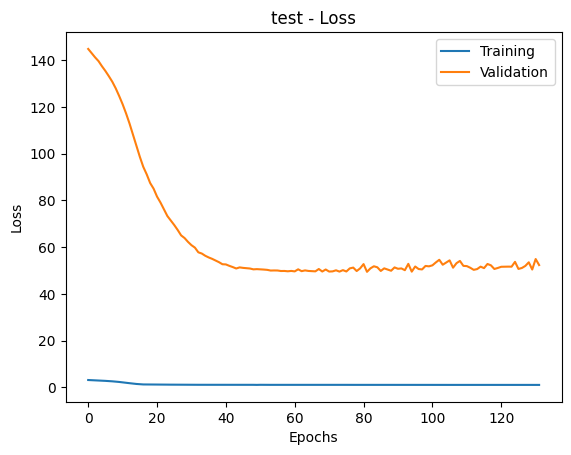

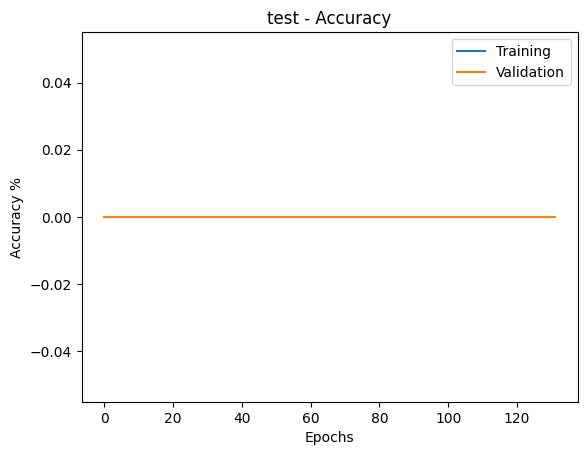

In [25]:
trainer.plot()

In [26]:
val_minima_points = val_df.filter(val_df["minimas"] == 1)

all_inputs, _, all_predictions = trainer.infer(DataLoader(val_dataset, batch_size=128))


# Plot close prices and minima
fig = go.Figure()

x = list(range(len(val_input.squeeze())))

norm_all_predictions = (all_predictions - all_predictions.min()) / (
    all_predictions.max() - all_predictions.min()
)

print(norm_all_predictions)

fig.add_trace(
    go.Scatter(
        x=list(range(30, 30 + len(norm_all_predictions))),
        y=norm_all_predictions.squeeze(),
        mode="lines",
        name="Predicted Minimas",
    )
)

# Line plot for Close prices
print(val_input.squeeze().cpu()[:, 0])

fig.add_trace(
    go.Scatter(
        x=x,
        y=val_input.squeeze().cpu()[:, 0],
        mode="lines",
        name="Close",
        line=dict(color="black"),
    )
)


# Create segments for the line
segments_x = []
segments_y = []
segments_colors = []

y = val_input.cpu()[0]
for i in range(30, 30 + len(all_predictions) - 1):
    segments_x.append([x[i], x[i + 1], None])  # None breaks the line
    segments_y.append([y[i], y[i + 1], None])
    segments_colors.append(
        norm_all_predictions[i - 30][0].item()
    )  # Use start point for color

fig.add_trace(
    go.Scatter(
        x=list(range(30, 30 + len(all_predictions))),
        y=val_input.squeeze().cpu()[30:, 0],
        mode="markers",
        name="Predicted Minimas",
        marker=dict(
            color=segments_colors,
            colorscale="Rainbow",
            cmin=0,
            cmax=1,
        ),
    )
)

fig.add_trace(
    go.Scatter(
        x=list(range(len(val_input))),
        y=all_predictions.squeeze(),
        mode="markers",
        name="Predicted Minimas",
        marker=dict(
            color=segments_colors,
            colorscale="Rainbow",
            cmin=0,
            cmax=1,
        ),
    )
)


fig.update_layout(
    title="Close Prices and Minimas",
    xaxis_title="Date",
    yaxis_title="Price",
    showlegend=True,
)

fig.show()


[[6.84388161e-01]
 [6.90428555e-01]
 [6.99479043e-01]
 [7.10183501e-01]
 [7.08762228e-01]
 [7.07766354e-01]
 [7.07566202e-01]
 [7.13263750e-01]
 [7.14982748e-01]
 [7.01405764e-01]
 [6.96781635e-01]
 [6.90355957e-01]
 [6.88636959e-01]
 [6.95513010e-01]
 [6.90203309e-01]
 [6.88334167e-01]
 [6.80930138e-01]
 [6.84675932e-01]
 [6.93596303e-01]
 [6.66474819e-01]
 [6.48964345e-01]
 [6.34161234e-01]
 [6.30150199e-01]
 [6.41935587e-01]
 [6.41552746e-01]
 [6.44079983e-01]
 [6.53303146e-01]
 [6.62668943e-01]
 [6.79126024e-01]
 [6.80116892e-01]
 [6.85641766e-01]
 [6.91942394e-01]
 [7.03027189e-01]
 [7.17187226e-01]
 [7.11624801e-01]
 [7.13191152e-01]
 [7.11875021e-01]
 [7.18811154e-01]
 [7.15698421e-01]
 [7.14872658e-01]
 [7.15087831e-01]
 [7.15500712e-01]
 [7.26788223e-01]
 [7.22526908e-01]
 [7.20800400e-01]
 [7.32841074e-01]
 [7.41946638e-01]
 [7.37817943e-01]
 [7.37312496e-01]
 [7.44418800e-01]
 [7.55193353e-01]
 [7.73084164e-01]
 [7.71470249e-01]
 [7.71492779e-01]
 [7.70471871e-01]
 [7.720232

/home/caleb/personal/uni/dlp/a3-rnn-stock-prediction/utils/training.py:188: FutureWarning:

You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.

/home/caleb/personal/uni/dlp/a3-rnn-stock-predictio